# Определение обсценной лексики

## Загрузки и импорты

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Библиотеки

In [1]:
!pip install gensim==3.8.1

In [ ]:
# !pip install --upgrade gensim

In [2]:
!pip install pymorphy2==0.9.1

### Загрузка предобученной векторной модели FastText Araneum Russicum

In [33]:
!wget https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz

--2021-04-05 09:02:14--  https://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextcbow_300_5_2018.tgz
Resolving rusvectores.org (rusvectores.org)... 116.203.104.23
Connecting to rusvectores.org (rusvectores.org)|116.203.104.23|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2691248108 (2.5G) [application/x-gzip]
Saving to: ‘araneum_none_fasttextcbow_300_5_2018.tgz’

araneum_none_fastte 100%[===================>]   2.51G  28.7MB/s    in 90s     

2021-04-05 09:03:45 (28.4 MB/s) - ‘araneum_none_fasttextcbow_300_5_2018.tgz’ saved [2691248108/2691248108]



### Импорты

In [3]:
import tarfile
import gensim
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')

from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, train_test_split
from pymorphy2 import MorphAnalyzer
from tqdm import tqdm
from string import punctuation

tokenizer = nltk.tokenize.WhitespaceTokenizer()
morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
vector_archive_path = "/content/araneum_none_fasttextcbow_300_5_2018.tgz"
vector_model_path = "/content/araneum_none_fasttextcbow_300_5_2018.model"
model_path = "/content/drive/MyDrive/thesis_datasets/obscene_detection.model"
obscene_data_path = "/content/drive/MyDrive/thesis_datasets/obscene_preprocessed_corpus.txt"
not_obscene_data_path = "/content/drive/MyDrive/thesis_datasets/2ch_corpus_preprocessed.txt"
corpus_path = "/content/drive/MyDrive/thesis_datasets/obscene_data.csv"

In [34]:
fasttext_file = tarfile.open(vector_archive_path, "r")
fasttext_file.extractall()

## Подготовка корпуса слов для обучения

In [9]:
# with open(obscene_data_path, "r") as obscene_data_file:
#   obscene_data = obscene_data_file.readlines()

In [10]:
# obscene_data[:20]

['6ля\n',
 '6ляд\n',
 'fuck\n',
 'pizd\n',
 'pizda\n',
 'pizdah\n',
 'pizdakh\n',
 'pizdam\n',
 'pizdami\n',
 'pizdax\n',
 'pizde\n',
 'pizdoi\n',
 'pizdoj\n',
 'pizdoy\n',
 'pizdu\n',
 'pizdy\n',
 'scheise\n',
 'scheisse\n',
 'shit\n',
 'suck\n']

In [11]:
# len(obscene_data)

9832

In [12]:
# with open(not_obscene_data_path, "r") as not_obscene_data_file:
#   not_obscene_data = not_obscene_data_file.readlines()

In [13]:
# not_obscene_data[:20]

['приближённый\n',
 'хаскеле-то\n',
 'лье\n',
 'плейофф\n',
 'привязывать\n',
 'атб\n',
 '3128\n',
 'комуфляж\n',
 'голова-туловище\n',
 'чикаго-кун\n',
 'уберняша\n',
 'редактироваться\n',
 'погаснуть\n',
 'ньюфажига\n',
 'лолмимо\n',
 'aodv\n',
 'efkz@yandex\n',
 '60кт\n',
 'military\n',
 'многопользовательский\n']

In [14]:
# len(not_obscene_data)

114660

In [15]:
# def corpus_preprocess(words: list) -> list:
    
#     words = [word.strip('\n').strip(punct) for word in words]

#     return words

In [16]:
# obscene_data = corpus_preprocess(obscene_data)
# obscene_data[:10]

['6ля',
 '6ляд',
 'fuck',
 'pizd',
 'pizda',
 'pizdah',
 'pizdakh',
 'pizdam',
 'pizdami',
 'pizdax']

In [17]:
# not_obscene_data = corpus_preprocess(not_obscene_data)
# not_obscene_data[:10]

['приближённый',
 'хаскеле-то',
 'лье',
 'плейофф',
 'привязывать',
 'атб',
 '3128',
 'комуфляж',
 'голова-туловище',
 'чикаго-кун']

In [18]:
# obscene_data = list(set(obscene_data))
# not_obscene_data = list(set(not_obscene_data))

In [19]:
# obscene_df = pd.DataFrame(data = obscene_data, columns = ['words'])
# not_obscene_df = pd.DataFrame(data = not_obscene_data, columns = ['words'])

In [20]:
# obscene_df['labels'] = [1 for _ in range(len(obscene_df))]
# not_obscene_df['labels'] = [0 for _ in range(len(not_obscene_df))]

In [21]:
# obscene_df.head()

,words,labels
0,пиздодельную,1
1,пиzdатый,1
2,перемандяхивать,1
3,нахуяпростой,1
4,размудохаться,1


In [22]:
# not_obscene_df.head()

,words,labels
0,24фикс,0
1,prime,0
2,htmlич,0
3,полтораста,0
4,кококок,0


In [23]:
# corpus = pd.concat([obscene_df, not_obscene_df], axis=0)

In [24]:
# corpus.head()

,words,labels
0,пиздодельную,1
1,пиzdатый,1
2,перемандяхивать,1
3,нахуяпростой,1
4,размудохаться,1


In [25]:
# len(corpus)

124172

In [26]:
# len(corpus.labels.unique())

2

In [27]:
# corpus.labels.unique()

array([1, 0])

In [28]:
# corpus = corpus.sample(frac=1)

In [29]:
# corpus.head()

,words,labels
55395,has,0
1559,выпиздошить,1
15179,обстаятельство,0
32323,dvach,0
45738,суккубик,0


In [30]:
# corpus.to_csv(corpus_path)

In [31]:
# len(corpus)

124172

## Бейзлайн

In [5]:
fasttext = KeyedVectors.load(vector_model_path)

In [56]:
corpus = pd.read_csv(corpus_path)
corpus.dropna(inplace=True)

In [57]:
len(corpus)

124171

In [58]:
def get_embeddings(words: list, vector_model=fasttext):
    vectors = np.zeros((len(words), 300))
    for i, word in enumerate(words):
        vector = vector_model[word]
        vectors[i] = vector
    return vectors

In [59]:
X = get_embeddings([word for word in corpus.words.values])
y = corpus.labels.values

In [60]:
X.shape, y.shape

((124171, 300), (124171,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logreg = LogisticRegression().fit(X_train, y_train)

In [62]:
y_pred = logreg.predict(X_test)

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     22871
           1       0.71      0.20      0.31      1964

    accuracy                           0.93     24835
   macro avg       0.82      0.60      0.64     24835
weighted avg       0.92      0.93      0.91     24835



In [64]:
f1_score(y_test, y_pred)

0.310934393638171

## Эксперимент по нормализации данных

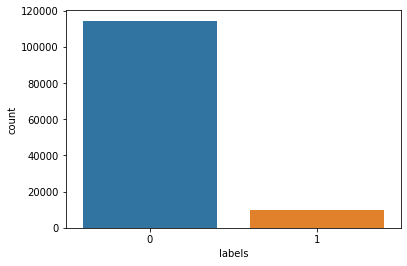

In [19]:
import seaborn as sns

sns.countplot(x='labels', data=corpus)

In [20]:
obscene = corpus[corpus.labels == 1]
not_obscene = corpus[corpus.labels == 0]

In [9]:
len(obscene)

9799

In [10]:
len(not_obscene)

114372

In [21]:
not_obscene = not_obscene.sample(13000, random_state=42)

In [22]:
corpus = pd.concat([obscene, not_obscene]).sample(frac=1)

In [23]:
corpus.head()

,Unnamed: 0,words,labels
91350,24951,хорват,0
90098,110946,чупачупс,0
116420,6260,тупиздень,1
68917,94795,веке>засада,0
39250,97484,шаталов,0


In [24]:
len(corpus)

22799

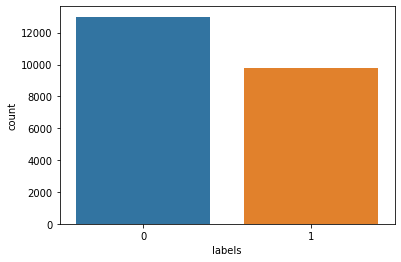

In [25]:
sns.countplot(x='labels', data=corpus)

In [26]:
X = get_embeddings(corpus.words.values.tolist())
y = corpus.labels.values

In [27]:
X.shape, y.shape

((22799, 300), (22799,))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
logreg = LogisticRegression().fit(X_train, y_train)

In [ ]:
y_pred = logreg.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      2606
           1       0.84      0.73      0.78      1954

    accuracy                           0.82      4560
   macro avg       0.83      0.81      0.82      4560
weighted avg       0.82      0.82      0.82      4560



In [ ]:
f1_score(y_test, y_pred)

0.7792349726775956

## Эксперимент с подбором параметров для логистической регрессии

In [35]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=0)
stratified_folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=0)

In [36]:
def make_grid_search(X_train, y_train, model=None, params_grid={'': []}, scoring='', n_jobs=0, folds=folds):
  grid_search = GridSearchCV(model, param_grid=params_grid, cv=folds, scoring=scoring, n_jobs=n_jobs)
  grid_search.fit(X_train, y_train)
  print(f'Model name: {model}')
  print(f'Best score: {grid_search.best_score_}')
  print(f'Best parameters: {grid_search.best_params_}')
  return grid_search.best_params_

In [ ]:
parameters_logreg = {'class_weight' : ['balanced', None],
                  'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
                  'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                  'C' : [0.15, 1.0, 10.0, 100.0],
                  'max_iter': [10,50,100]
                 }

In [ ]:
logreg = LogisticRegression(random_state=42)

In [ ]:
%%time
best_params_folds = make_grid_search(X_train, y_train, logreg, parameters_logreg, 'f1_macro', n_jobs=5, folds=folds)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Best score: 0.8432978345035046
Best parameters: {'C': 0.15, 'class_weight': 'balanced', 'max_iter': 10, 'penalty': 'none', 'solver': 'saga'}
CPU times: user 12.8 s, sys: 1.14 s, total: 13.9 s
Wall time: 29min 13s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
best_params_folds

{'C': 0.15,
 'class_weight': 'balanced',
 'max_iter': 10,
 'penalty': 'none',
 'solver': 'saga'}

In [ ]:
%%time
best_params_stratified_folds = make_grid_search(X_train, y_train, logreg, parameters_logreg, 'f1_macro', n_jobs=5, folds=stratified_folds)

Best score: 0.8436269059601678
Best parameters: {'C': 100.0, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
CPU times: user 14.1 s, sys: 1.07 s, total: 15.2 s
Wall time: 27min 19s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
best_params_stratified_folds

{'C': 100.0,
 'class_weight': 'balanced',
 'max_iter': 100,
 'penalty': 'l2',
 'solver': 'lbfgs'}

In [49]:
best_params_stratified_folds['random_state'] = 42

In [ ]:
logreg = LogisticRegression(**best_params_stratified_folds).fit(X_train, y_train)

In [52]:
y_pred = logreg.predict(X_test)

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      2585
           1       0.81      0.85      0.83      1975

    accuracy                           0.85      4560
   macro avg       0.85      0.85      0.85      4560
weighted avg       0.85      0.85      0.85      4560



In [54]:
f1_score(y_test, y_pred)

0.8303948348646635

## Эксперимент с использованием метода опорных векторов на нормализованных данных

In [29]:
from sklearn.svm import LinearSVC

In [30]:
linearsvc = LinearSVC().fit(X_train, y_train)

In [32]:
y_pred = linearsvc.predict(X_test)

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2585
           1       0.85      0.78      0.82      1975

    accuracy                           0.85      4560
   macro avg       0.85      0.84      0.84      4560
weighted avg       0.85      0.85      0.85      4560



In [34]:
f1_score(y_test, y_pred)

0.8150883671854392

In [55]:
accuracy_score(y_test, y_pred)

0.850219298245614

## Эксперимент с подбором параметров для метода опорных векторов

In [37]:
parameters_linear_svc = {'loss': ["hinge", "squared_hinge"],
                  'penalty' : ['l1', 'l2'],
                  'C' : [0.15, 1.0, 10.0, 100.0],
                  'class_weight' : ['balanced', None],
                    'tol': [1e-2, 1e-3, 1e-4]}  

In [38]:
linearsvc = LinearSVC(random_state=42)

In [39]:
%%time
best_params_folds = make_grid_search(X_train, y_train, linearsvc, parameters_linear_svc, 'f1_macro', n_jobs=5, folds=folds)

Model name: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)
Best score: 0.8468222700241345
Best parameters: {'C': 100.0, 'class_weight': 'balanced', 'loss': 'hinge', 'penalty': 'l2', 'tol': 0.01}
CPU times: user 13.1 s, sys: 852 ms, total: 13.9 s
Wall time: 12min 14s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [40]:
best_params_folds

{'C': 100.0,
 'class_weight': 'balanced',
 'loss': 'hinge',
 'penalty': 'l2',
 'tol': 0.01}

In [41]:
%%time
best_params_stratified_folds = make_grid_search(X_train, y_train, linearsvc, parameters_linear_svc, 'f1_macro', n_jobs=5, folds=stratified_folds)

Model name: LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)
Best score: 0.8449464186177416
Best parameters: {'C': 100.0, 'class_weight': 'balanced', 'loss': 'hinge', 'penalty': 'l2', 'tol': 0.01}
CPU times: user 13.2 s, sys: 933 ms, total: 14.1 s
Wall time: 12min 42s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [42]:
best_params_stratified_folds

{'C': 100.0,
 'class_weight': 'balanced',
 'loss': 'hinge',
 'penalty': 'l2',
 'tol': 0.01}

In [43]:
best_params_folds['random_state'] = 42

In [44]:
linearsvc = LinearSVC(**best_params_folds).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [45]:
y_pred = linearsvc.predict(X_test)

In [46]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2585
           1       0.82      0.85      0.83      1975

    accuracy                           0.85      4560
   macro avg       0.85      0.85      0.85      4560
weighted avg       0.85      0.85      0.85      4560



In [47]:
f1_score(y_test, y_pred)

0.833998005982054

In [48]:
accuracy_score(y_test, y_pred)

0.8539473684210527

## Выводы

Лучшие результаты показал метод опорных векторов, обученный на нормализованных данных.

| Метрика | Значение|
|------------- | -------------|
| macro f-score | 0.8339 |
| accuracy | 0.8539 |

Параметры модели

| Параметр | Значение|
|------------- | -------------|
| C | 100.0|
| class_weight | 'balanced' |
| loss | 'hinge' |
| penalty | 'l2'|
|tol | 0.01 |

Все результаты

| Модель | Метрика | Значение|
|------------- |------------- | -------------|
|baseline logreg | macro f-score | 0.3109 |
| logreg normalized data | macro f-score | 0.7792 |
| logreg normalized data and best params | macro f-score | 0.8304 |
| linear svc normalized data | macro f-score | 0.8150 |
| linear svc normalized data  and best params | macro f-score | **0.8339** |


## Эксперимент с использованием разных классификаторов

In [ ]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
bernoulli_nb = BernoulliNB()
gaussian_nb = GaussianNB()
decision_tree = DecisionTreeClassifier()
kneighbors = KNeighborsClassifier()
random_forest = RandomForestClassifier()
sgd = SGDClassifier()

In [ ]:
parameters_bernoulli_nb = {'alpha': [0.0, 0.5, 1.0]}

parameters_gaussian_nb = {'var_smoothing': [1e-8, 1e-9, 1e-10]}

parameters_decision_tree = {'criterion': ["gini", "entropy"],
                            'splitter': ["best", "random"],
                            'max_depth': [None, 1, 3, 5],
                            'min_samples_split': [2, 3, 5],
                            'min_samples_leaf': [1, 3, 5],
                            'max_features': [None, "auto", "sqrt", "log2"],
                            'class_weight': [None, "balanced"]}

parameters_kneighbors = {'n_neighbors': [3, 4, 5],
                            'weights': ["uniform", "distance"],
                            'algorithm': ["auto", "ball_tree", "kd_tree", "brute"],
                            'leaf_size': [10, 20, 30]}

parameters_random_forest = {'n_estimators': [50, 100, 200],
                            'criterion': ["gini", "entropy"],
                            'max_depth': [None, 1, 3, 5],
                            'min_samples_split': [2, 3, 5],
                            'min_samples_leaf': [1, 3, 5],
                            'max_features': [None, "auto", "sqrt", "log2"],
                            'class_weight': [None, "balanced", "balanced_subsample"]}

parameters_sgd = {'loss': ["hinge", "log", "modified_huber", "squared_hinge", "perceptron"],
                     'penalty' : ['l1', 'l2', 'elasticnet'],
                     'alpha': [0.00001, 0.0001, 0.001],
                     'tol': [1e-2, 1e-3, 1e-4], 
                     'class_weight' : ['balanced', None]}                  

KFold

In [ ]:
%%time
best_params_folds_bernoulli_nb = make_grid_search(X_train, y_train, bernoulli_nb, parameters_bernoulli_nb, 'f1_macro', n_jobs=5, folds=folds)

Model name: BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Best score: 0.8120541050361496
Best parameters: {'alpha': 0.0}
CPU times: user 265 ms, sys: 307 ms, total: 572 ms
Wall time: 4.67 s


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


In [ ]:
%%time
best_params_folds_gaussian_nb = make_grid_search(X_train, y_train, gaussian_nb, parameters_gaussian_nb, 'f1_macro', n_jobs=5, folds=folds)

Model name: GaussianNB(priors=None, var_smoothing=1e-09)
Best score: 0.6233939288518677
Best parameters: {'var_smoothing': 1e-08}
CPU times: user 150 ms, sys: 35 ms, total: 185 ms
Wall time: 1.54 s


In [ ]:
%%time
best_params_folds_decision_tree = make_grid_search(X_train, y_train, decision_tree, parameters_decision_tree, 'f1_macro', n_jobs=5, folds=folds)

Model name: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Best score: 0.7909074686683459
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'splitter': 'best'}
CPU times: user 38.8 s, sys: 1.61 s, total: 40.4 s
Wall time: 51min 8s


In [ ]:
%%time
best_params_folds_kneighbors = make_grid_search(X_train, y_train, kneighbors, parameters_kneighbors, 'f1_macro', n_jobs=5, folds=folds)

In [ ]:
%%time
best_params_folds_random_forest = make_grid_search(X_train, y_train, random_forest, parameters_random_forest, 'f1_macro', n_jobs=5, folds=folds)

In [ ]:
%%time
best_params_folds_sgd = make_grid_search(X_train, y_train, sgd, parameters_sgd, 'f1_macro', n_jobs=5, folds=folds)

In [ ]:
%%time
best_params_folds_svc = make_grid_search(X_train, y_train, svc, parameters_svc, 'f1_macro', n_jobs=5, folds=folds)

In [ ]:
%%time
best_params_folds_linear_svc = make_grid_search(X_train, y_train, linear_svc, parameters_linear_svc, 'f1_macro', n_jobs=5, folds=folds)

StratifiedKFold

In [ ]:
%%time
best_params_stratified_folds_bernoulli_nb = make_grid_search(X_train, y_train, bernoulli_nb, parameters_bernoulli_nbg, 'f1_macro', n_jobs=5, folds=stratified_folds)

In [ ]:
%%time
best_params_stratified_folds_gaussian_nb = make_grid_search(X_train, y_train, gaussian_nb, parameters_gaussian_nb, 'f1_macro', n_jobs=5, folds=stratified_folds)

In [ ]:
%%time
best_params_stratified_folds_decision_tree = make_grid_search(X_train, y_train, decision_tree, parameters_decision_tree, 'f1_macro', n_jobs=5, folds=stratified_folds)

In [ ]:
%%time
best_params_stratified_folds_kneighbors = make_grid_search(X_train, y_train, kneighbors, parameters_kneighbors, 'f1_macro', n_jobs=5, folds=stratified_folds)

In [ ]:
%%time
best_params_stratified_folds_random_forest = make_grid_search(X_train, y_train, random_forest, parameters_random_forest, 'f1_macro', n_jobs=5, folds=stratified_folds)

In [ ]:
%%time
best_params_stratified_folds_sgd = make_grid_search(X_train, y_train, sgd, parameters_sgd, 'f1_macro', n_jobs=5, folds=stratified_folds)

In [ ]:
%%time
best_params_stratified_folds_svc = make_grid_search(X_train, y_train, svc, parameters_svc, 'f1_macro', n_jobs=5, folds=stratified_folds)

In [ ]:
%%time
best_params_stratified_folds_linear_svc_clf = make_grid_search(X_train, y_train, linear_svc_clf, linear_svc_clf, 'f1_macro', n_jobs=5, folds=stratified_folds)